In [1]:
import glob
import tifffile
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras_hub
import tensorflow as tf

2025-05-15 14:19:30.520339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747333170.531901   27135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747333170.535356   27135 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 14:19:30.549285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/albert-wang/miniforge3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please u

In [2]:
def read_image(image_path):
    rfp = tifffile.imread(image_path)
    rfp_zscore = zscore(rfp, axis=None)
    image = np.zeros((512, 512, 3), np.float32)
    image[..., 0] = rfp_zscore
    image[..., 1] = rfp_zscore
    image[..., 2] = rfp_zscore
    return image

def read_label(label_path):
    label = tifffile.imread(label_path)
    return np.stack([~label, label], axis=-1).astype(bool)

label_paths = sorted(glob.glob('../training/*_label.tif'))
image_paths = [i[:-10] + '.tif' for i in label_paths]

images = np.array([read_image(image_path) for image_path in image_paths])
labels = np.array([read_label(label_path) for label_path in label_paths])
images.shape, labels.shape

((183, 512, 512, 3), (183, 512, 512, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7229746..23.530443].


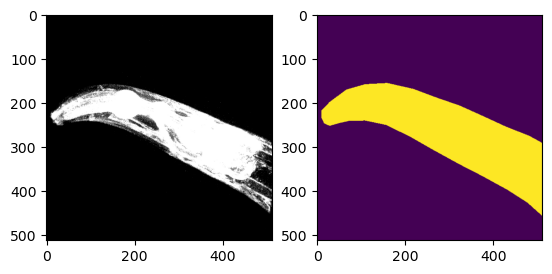

In [3]:
def random_flip():
    for i in range(len(images)):
        seed1, seed2 = np.random.randint(2), np.random.randint(2)
        if seed1:
            images[i], labels[i] = images[i, ::-1], labels[i, ::-1]
        if seed2:
            images[i], labels[i] = images[i, :, ::-1], labels[i, :, ::-1]

random_flip()

i = 10
plt.subplot(121)
plt.imshow(images[i])
plt.subplot(122)
plt.imshow(labels[i, :, :, 1])

In [4]:
weights_path = 'deeplab.weights.h5'
learning_rate = 5e-5

model = keras_hub.models.ImageSegmenter.from_preset('deeplab_v3_plus_resnet50_pascalvoc', num_classes=2, compile=False)
model.load_weights(weights_path)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')
model.summary()

I0000 00:00:1747333173.969323   27135 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Preprocessor: "deep_lab_v3_image_segmenter_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deep_lab_v3_image_converter (DeepLabV3ImageConverter)         │                   Image size: (512, 512) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "deep_lab_v3_image_segmenter"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                           │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ deep_lab_v3_backbone (DeepLabV3Backbone)      │ (None, None, None, 256)            │          39,190,656 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ segmentation_output (Conv2D)                  │ (None, None, None, 2)              │                 512 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 39,191,168 (149.50 MB)

 Trainable params: 39,134,368 (149.29 MB)

 Non-trainable params: 56,800 (221.88 KB)

In [5]:
batch_size = 4
epochs = 20

checkpoint_callback = keras.callbacks.ModelCheckpoint(weights_path, save_weights_only=True, save_best_only=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)
try:
    model.fit(images, labels, batch_size=batch_size, epochs=epochs, validation_split=0.1,
              callbacks=[checkpoint_callback, tensorboard_callback])
except KeyboardInterrupt:
    print('Training interrupted')

Epoch 1/20


/home/albert-wang/miniforge3/envs/ml/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)
I0000 00:00:1747333192.160494   27208 service.cc:148] XLA service 0x7a561c025600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747333192.160535   27208 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-15 14:19:52.640809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747333194.455312   27208 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-15 14:20:00.135026: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to alloc

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - categorical_accuracy: 0.9973 - loss: 0.0066

2025-05-15 14:20:39.154247: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-15 14:20:44.853254: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1132462080 exceeds 10% of free system memory.
2025-05-15 14:20:45.090566: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1132462080 exceeds 10% of free system memory.
2025-05-15 14:20:45.338121: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1132462080 exceeds 10% of free system memory.


41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 595ms/step - categorical_accuracy: 0.9973 - loss: 0.0067 - val_categorical_accuracy: 0.9884 - val_loss: 0.0465
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - categorical_accuracy: 0.9977 - loss: 0.0054

2025-05-15 14:20:59.093014: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1132462080 exceeds 10% of free system memory.
2025-05-15 14:20:59.328483: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1132462080 exceeds 10% of free system memory.


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - categorical_accuracy: 0.9977 - loss: 0.0054 - val_categorical_accuracy: 0.9881 - val_loss: 0.0491
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - categorical_accuracy: 0.9980 - loss: 0.0047 - val_categorical_accuracy: 0.9881 - val_loss: 0.0488
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - categorical_accuracy: 0.9982 - loss: 0.0045 - val_categorical_accuracy: 0.9882 - val_loss: 0.0492
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - categorical_accuracy: 0.9982 - loss: 0.0044 - val_categorical_accuracy: 0.9880 - val_loss: 0.0513
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - categorical_accuracy: 0.9982 - loss: 0.0043 - val_categorical_accuracy: 0.9880 - val_loss: 0.0511
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - categorical_accuracy: 0.9982 - loss: 0.0043 - val_categorical_accuracy: 0.9882 - val_loss: 0.0513
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - categorical_accuracy: 0.9980 - loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7664033..17.059576].


105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


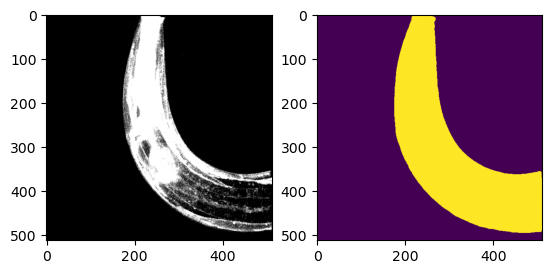

In [26]:
i = np.random.randint(0, len(images))
print(i)

plt.subplot(121)
plt.imshow(images[i])
plt.subplot(122)
label = np.argmax(model.predict(np.expand_dims(images[i], axis=0))[0], axis=2)
plt.imshow(label)